# Downloading Required files and Libraries

In [1]:
import requests
import os

In [2]:
url = "https://huggingface.co/h94/IP-Adapter/resolve/main/models/ip-adapter-full-face_sd15.bin?download=true"
response = requests.get(url)
with open("ip-adapter-full-face_sd15.bin", "wb") as f:
    f.write(response.content)

In [3]:
os.makedirs('image_encoder')

In [4]:
url = "https://huggingface.co/h94/IP-Adapter/resolve/main/models/image_encoder/config.json?download=true"
response = requests.get(url)
with open("/kaggle/working/image_encoder/config.json", "wb") as f:
    f.write(response.content)

In [5]:
url = "https://huggingface.co/h94/IP-Adapter/resolve/main/models/image_encoder/model.safetensors?download=true"
response = requests.get(url)
with open("/kaggle/working/image_encoder/model.safetensors", "wb") as f:
    f.write(response.content)

In [6]:
url = "https://huggingface.co/h94/IP-Adapter/resolve/main/models/image_encoder/pytorch_model.bin?download=true"
response = requests.get(url)
with open("/kaggle/working/image_encoder/pytorch_model.bin", "wb") as f:
    f.write(response.content)

In [7]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.5 MB/s eta 0:00:00:00:010:01


In [8]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 649.6 kB/s eta 0:00:00a 0:00:01


In [9]:
!pip install ip_adapter

In [10]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapterFull

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-04-01 05:13:11.052686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 05:13:11.052833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 05:13:11.312722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "/kaggle/working/image_encoder"
ip_ckpt = "/kaggle/working/ip-adapter-full-face_sd15.bin"
device = "cuda"

In [12]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [13]:
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
ip_model = IPAdapterFull(pipe, image_encoder_path, ip_ckpt, device, num_tokens=257)

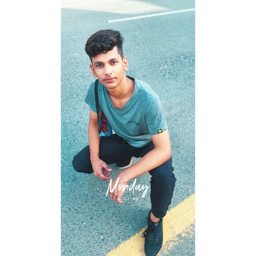

In [15]:
image = Image.open("/kaggle/input/mysamplepicture/Ahmad.jpg")
image.resize((256, 256))

  0%|          | 0/50 [00:00<?, ?it/s]

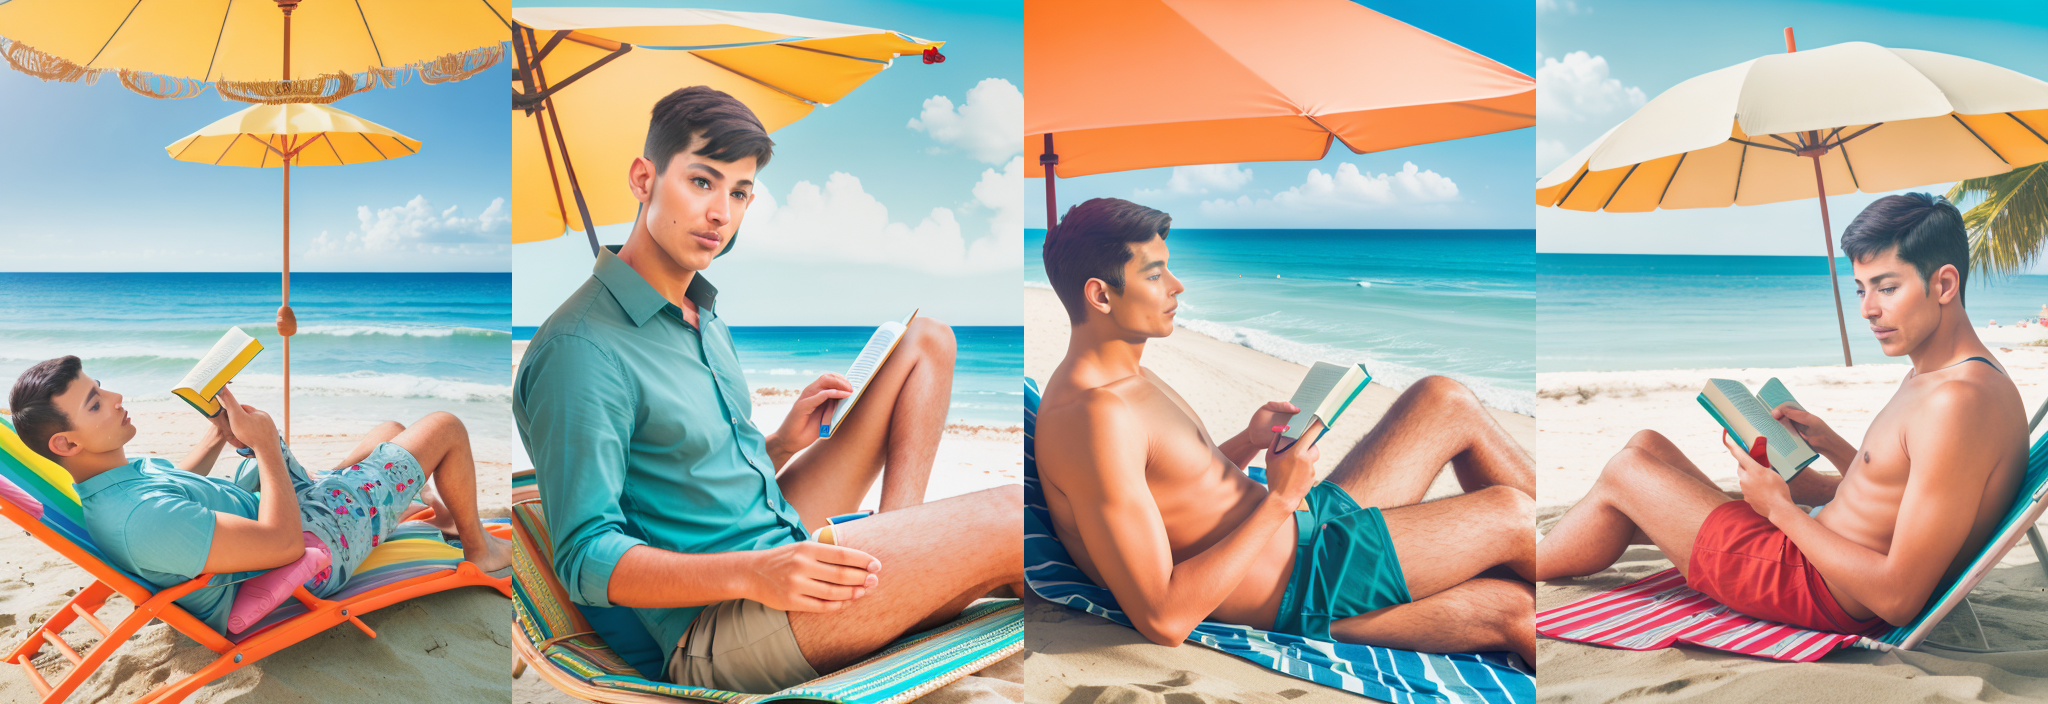

In [16]:
images = ip_model.generate(
    pil_image=image, num_samples=4, prompt='Generate a vivid and lifelike image of a man sitting on a sandy beach on a sunny day, comfortably reading a book under a colorful beach umbrella. The scene should capture the serene atmosphere with warm sunlight, gentle waves, and the man engrossed in his reading, conveying a sense of relaxation and tranquility.',scale=0.7, width=512, height=704, num_inference_steps=50, seed=42
)
grid = image_grid(images, 1, 4)
grid